# Downsampling 10x Data
Here we attempt to downsample the 10x data to see if it is more concordant with the XYZeq data in terms of cell types and proportion of each cell type. If it is, we may consider using downsampled data, as we might argue it's a more apples-to-apples comparison.

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix, find
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings
import seaborn as sns

from IPython.display import display, HTML

In [2]:
print(sc.__version__)

1.5.1


In [3]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [4]:
prefix = '/data/xyzeq/box.data3/data/'

## Load in the Data

In [5]:
data = dict()

In [5]:
data['10x'] = dict()
data['XYZ'] = dict()
data['10x']['raw'] = sc.read_10x_h5(prefix + 'Liver/10X_raw_feature_bc_matrix.h5')
data['10x']['raw'].var_names_make_unique()
data['XYZ']['raw'] = sc.read_loom(prefix + 'Liver/L20C1_all_cells_mouse_genes.loom', validate=False)
data['XYZ']['raw'].var_names_make_unique()

reading /data/xyzeq/box.data3/data/Liver/10X_raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Subset the 10x Cells
I want to capture as many of the 10x cells as possible. Because I only want to compare mouse cells, I'm going to keep only the cells with high counts of mouse genes and low counts of human genes.

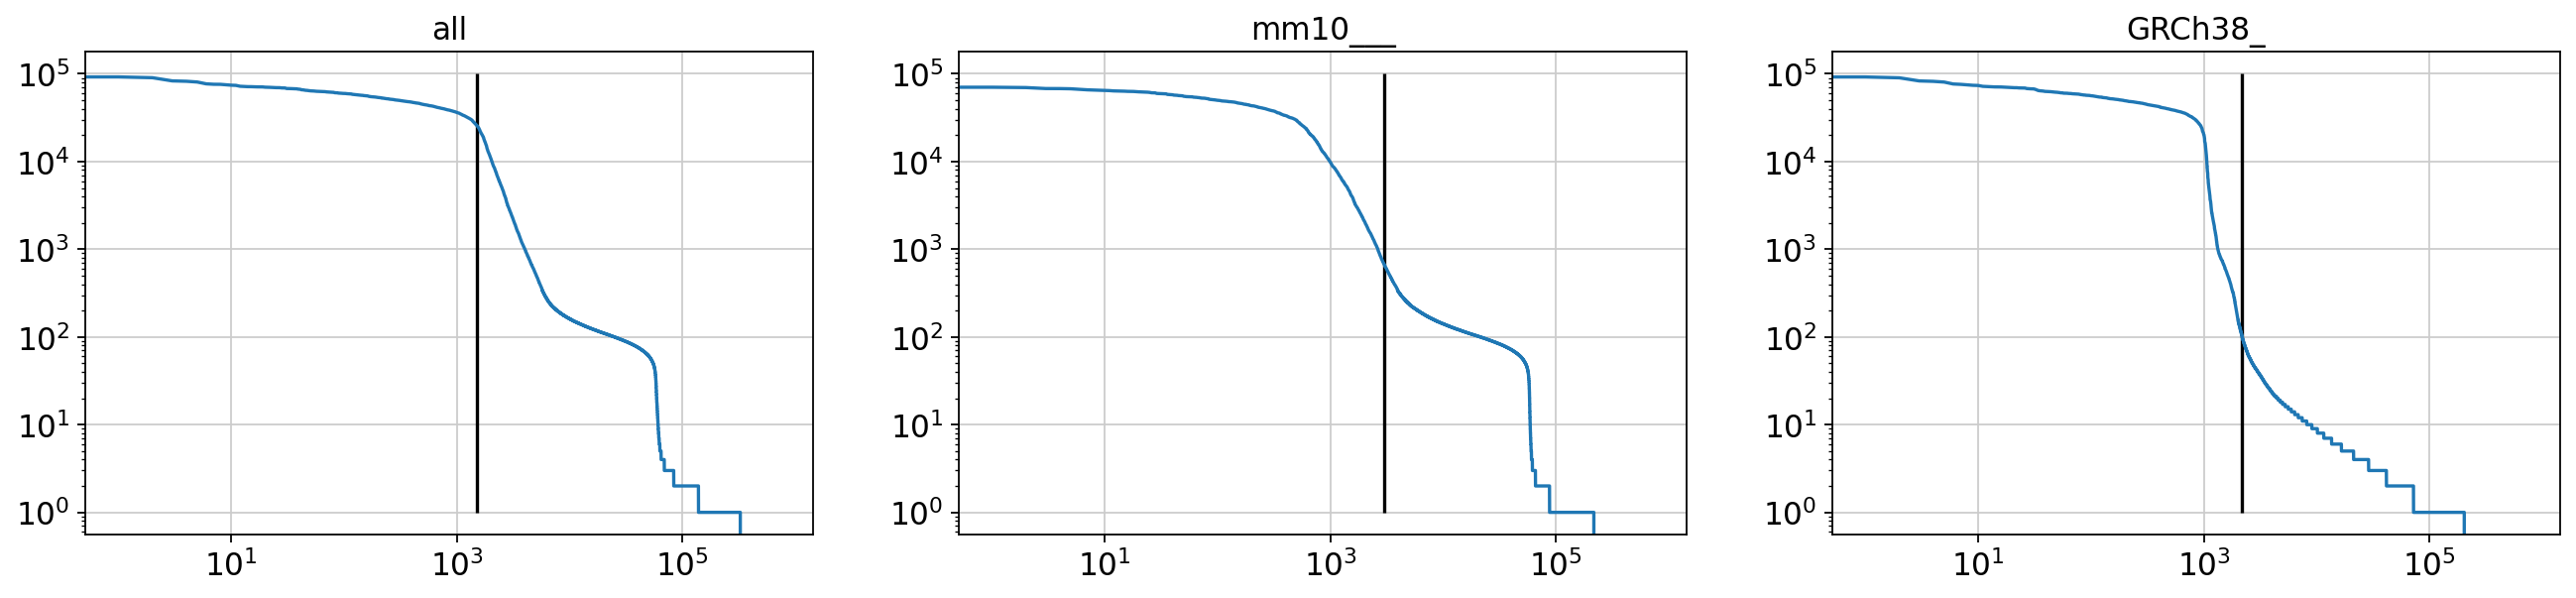

In [6]:
vlines=[1500, 3000, 2200]
fig, axes = plt.subplots(1,3,figsize=(20,4))
for var, ax, vline in zip(['all', 'mm10___', 'GRCh38_'], np.ravel(axes), vlines):
    if var == 'all': 
        ax.plot(np.sort(np.ravel(data['10x']['raw'].X.sum(1)))[::-1])
    else:
        ax.plot(np.sort(np.ravel(data['10x']['raw'][:,[i for i in data['10x']['raw'].var_names if i.startswith(var)]].X.sum(1)))[::-1])
    ax.set_title(var)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.vlines(vline,1,1e5, color='k')

In [7]:
data['10x']['raw'].obs['mouse_counts'] = data['10x']['raw'][:,[i for i in data['10x']['raw'].var_names if i.startswith('mm10___')]].X.sum(1)
data['10x']['raw'].obs['human_counts'] = data['10x']['raw'][:,[i for i in data['10x']['raw'].var_names if i.startswith('GRCh38_')]].X.sum(1)

Where to draw this is totally subjective. I realized with a value of `3000` I'm going deep into the mouse "knee", more than I would ordinarily.

In [8]:
mouse_thresh = 3000
human_thresh = 2200

In [9]:
mouse_only_cells = np.setdiff1d(data['10x']['raw'].obs['mouse_counts'].sort_values(ascending=False).index[:mouse_thresh].values,
                                data['10x']['raw'].obs['human_counts'].sort_values(ascending=False).index[:human_thresh].values)

In [10]:
data['10x']['mouse'] = data['10x']['raw'][:,[i for i in data['10x']['raw'].var_names if i.startswith('mm10___')]].copy()
data['10x']['mouse'].var_names = [i[7:] for i in data['10x']['mouse'].var_names]
data['10x']['mouse'] = data['10x']['mouse'][mouse_only_cells,:].copy()

In [11]:
data['XYZ']['mouse'] = data['XYZ']['raw'][data['XYZ']['raw'].obs['cell_call'] == 'M',:].copy()

In [12]:
data['10x']['mouse'].obs['mouse_counts']

AAACCTGAGAATGTGT-1    30535.0
AAACCTGAGGGTATCG-1      747.0
AAACCTGCAAGCTGAG-1    11212.0
AAACCTGCAGGGTTAG-1     9544.0
AAACCTGGTCGCTTCT-1     5291.0
                       ...   
TTTGTCAAGCCAACAG-1     4621.0
TTTGTCAAGTGGGTTG-1    48437.0
TTTGTCACATTACGAC-1     2598.0
TTTGTCAGTCCAGTGC-1     1466.0
TTTGTCATCAGGTTCA-1     2422.0
Name: mouse_counts, Length: 2900, dtype: float32

In [13]:
data['XYZ']['mouse'].obs['mouse_counts']

L20C1_P1A01F.CTCATACCTGCTACCT    5372.0
L20C1_P1A01F.GCGCTCCTTCCGCTAA    1256.0
L20C1_P1A02F.CGATAGCCTTATTGCT     700.0
L20C1_P1A02F.GTGCTCGTTAGGTTCT    1345.0
L20C1_P1A02F.TCAATTCGCGCACCGA     456.0
                                  ...  
L20C1_P4H12F.GGTAATGACTTGCAGA    3603.0
L20C1_P4H12F.GAGACATCCGGTATAC     544.0
L20C1_P4H12F.TTGGACGTGAGATAGT     934.0
L20C1_P4H12F.TCCACTGGAGTGTCGC     633.0
L20C1_P4H12F.TCCACCGTATGCGCTG     751.0
Name: mouse_counts, Length: 2389, dtype: float64

## Compare Counts

In [14]:
df_10x = pd.DataFrame(zip(it.repeat('10x'), data['10x']['mouse'].obs['mouse_counts']), columns=['method', 'counts'])
df_XYZ = pd.DataFrame(zip(it.repeat('XYZ'), data['XYZ']['mouse'].obs['mouse_counts']), columns=['method', 'counts'])

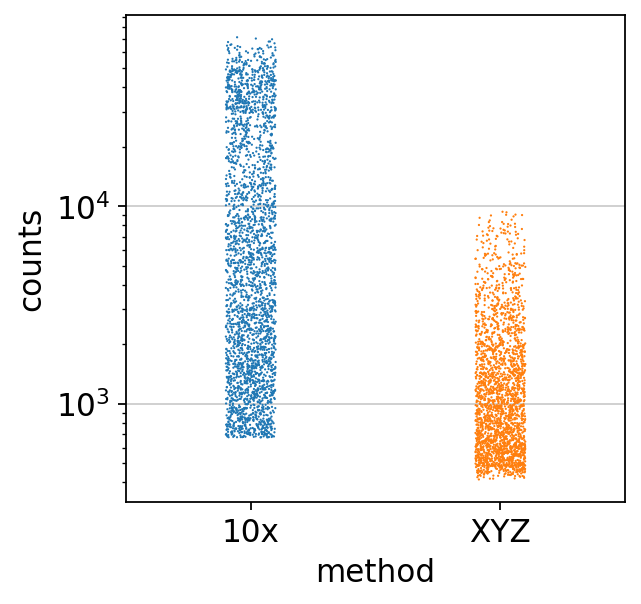

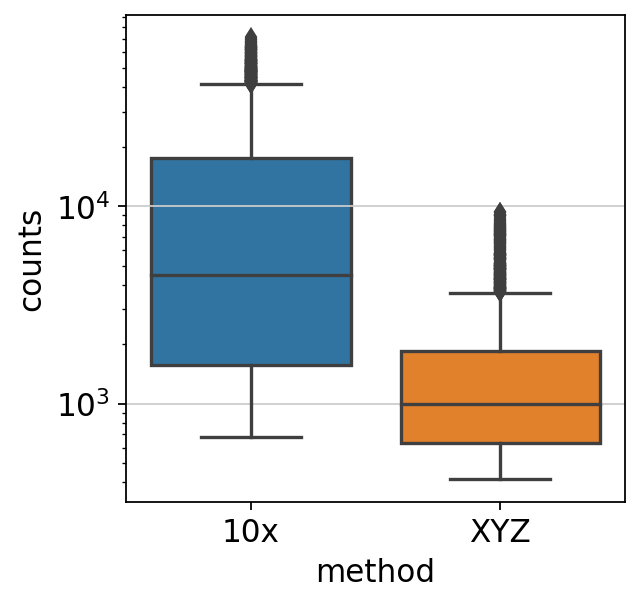

In [15]:
sns.stripplot(data=pd.concat([df_10x, df_XYZ]) ,y='counts',x='method',size=1);
plt.yscale('log')
plt.show()
sns.boxplot(data=pd.concat([df_10x, df_XYZ]), y='counts', x='method');
plt.yscale('log')
plt.show()

## Filter for Percent Mito

In [16]:
genelist = data['10x']['mouse'].var_names.tolist()
mito_genes_names = [gn for gn in genelist if gn.startswith('mt-')]
mito_genes = [genelist.index(gn) for gn in mito_genes_names]
mito_counts = np.ravel(np.sum(data['10x']['mouse'][:, mito_genes].X, axis=1))

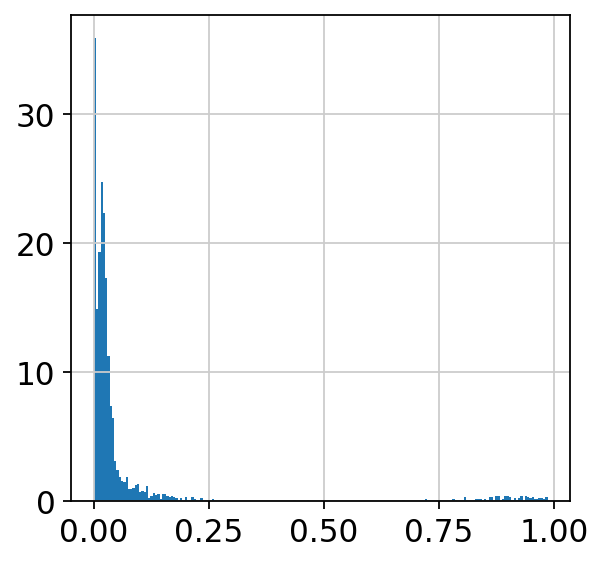

In [17]:
data['10x']['mouse'].obs['percent_mito'] = mito_counts / data['10x']['mouse'].obs['mouse_counts'].values
plt.hist(data['10x']['mouse'].obs['percent_mito'].values,bins=200,density=True);

In [18]:
data['10x']['mouse'] = data['10x']['mouse'][data['10x']['mouse'].obs['percent_mito'] < 0.25].copy()

In [19]:
data['10x']['mouse'] = data['10x']['mouse'][(np.ravel(data['10x']['mouse'].X.sum(1)) > 0),:].copy()

### Export Small Matrices

In [20]:
data['XYZ']['mouse'].var_names = [i[7:] for i in data['XYZ']['mouse'].var_names]

In [21]:
genes = np.intersect1d(data['XYZ']['mouse'].var_names.values, data['10x']['mouse'].var_names.values)

In [22]:
cells_XYZeq = np.random.choice(data['XYZ']['mouse'].obs_names.values, size=1000, replace=False)
cells_10x = np.random.choice(data['10x']['mouse'].obs_names.values, size=1000, replace=False)

In [23]:
df_10x_export = data['10x']['mouse'][cells_10x,:][:,genes].to_df()
df_XYZ_export = data['XYZ']['mouse'][cells_XYZeq,:][:,genes].to_df()

In [24]:
print(df_10x_export.shape)
print(df_XYZ_export.shape)

(1000, 23329)
(1000, 23329)


In [25]:
df_10x = pd.DataFrame(zip(it.repeat('10x'), pd.Series(df_10x_export.sum(1), name='mouse_counts')), columns=['method', 'counts'])
df_XYZ = pd.DataFrame(zip(it.repeat('XYZ'), pd.Series(df_XYZ_export.sum(1), name='mouse_counts')), columns=['method', 'counts'])

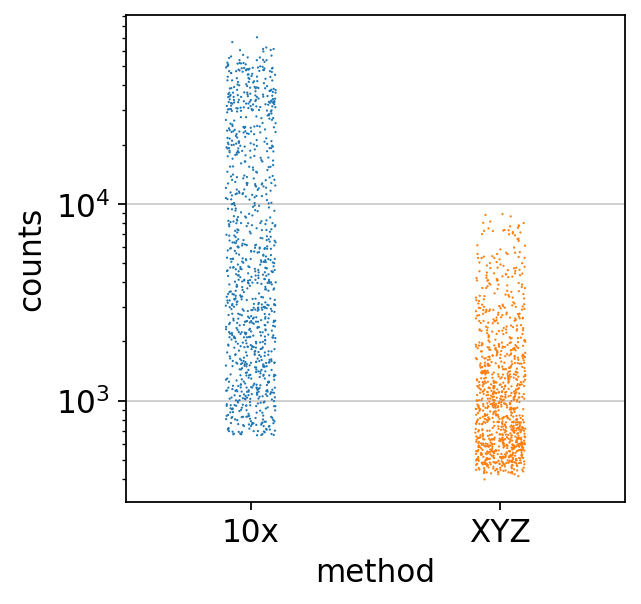

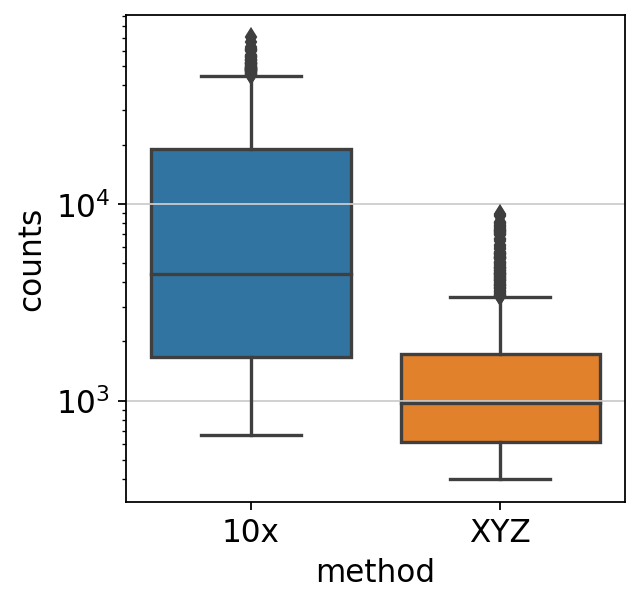

In [26]:
sns.stripplot(data=pd.concat([df_10x, df_XYZ]) ,y='counts',x='method',size=1);
plt.yscale('log')
plt.show()
sns.boxplot(data=pd.concat([df_10x, df_XYZ]), y='counts', x='method');
plt.yscale('log')
plt.show()

In [27]:
# df_10x_export.to_csv('/data/xyzeq/10x.counts.sample.csv')
# df_XYZ_export.to_csv('/data/xyzeq/XYZ.counts.sample.csv')

## Downsample

Here, I downsample by subtracting one from the entire 10x matrix until the mean is within 5% of the XYZeq matrix. 

In [28]:
# mean_xyz = data['XYZ']['mouse'].obs['mouse_counts'].mean()
# mean_10x = 0
# eps = mean_xyz*0.05 # within 5% of the mean
# sp = data['10x']['mouse'].X.toarray()
# counter = 0
# while abs(mean_10x - mean_xyz) > eps:
#     sp -= 1
#     sp = np.where(sp < 0, 0, sp) # one begs the question: could i have just done np.where(sp > 0, sp - 1, 0)
#     counter += 1
#     mean_10x = sp.sum(1).mean()
# #     print(counter)
#     if counter % 100 == 0:
#         print(mean_10x)

In [29]:
# data['10x']['mouse_down'] = data['10x']['mouse'].copy()
# data['10x']['mouse_down'].X = sp
# data['10x']['mouse_down'].obs['mouse_counts'] = data['10x']['mouse_down'].X.sum(1)

In [30]:
# data['10x']['mouse_down'].obs['mouse_counts'].mean()

In [31]:
# data['XYZ']['mouse'].obs['mouse_counts'].mean()

In [32]:
# data['10x']['mouse_down'] = data['10x']['mouse_down'][(data['10x']['mouse_down'].obs['mouse_counts'] > 0),:].copy()

In [33]:
# df_10x = pd.DataFrame(zip(it.repeat('10x'), data['10x']['mouse_down'].obs['mouse_counts']), columns=['method', 'counts'])
# df_XYZ = pd.DataFrame(zip(it.repeat('XYZ'), data['XYZ']['mouse'].obs['mouse_counts']), columns=['method', 'counts'])

In [34]:
# sns.stripplot(data=pd.concat([df_10x, df_XYZ]) ,y='counts',x='method',size=1);
# plt.yscale('log')
# plt.show()
# sns.boxplot(data=pd.concat([df_10x, df_XYZ]), y='counts', x='method');
# plt.yscale('log')
# plt.show()

The means might be the same, but unfortunately the medians are way off.

## Downsample

Here, I downsample by subtracting one from the entire 10x matrix until the mean is within 5% of the XYZeq matrix. 

In [35]:
mean_xyz = data['XYZ']['mouse'].obs['mouse_counts'].mean()
mean_10x = data['10x']['mouse'].obs['mouse_counts'].mean()

In [36]:
p = mean_xyz/mean_10x

In [37]:
lil = data['10x']['mouse'].X.tolil()

In [38]:
for i, j, v in tqdm(zip(*find(data['10x']['mouse'].X)), total=data['10x']['mouse'].X.getnnz()):
    lil[i, j] = np.random.binomial(n=v,p=p,size=1)

In [39]:
data['10x']['mouse_down'] = data['10x']['mouse'].copy()
data['10x']['mouse_down'].X = lil.tocsr()
data['10x']['mouse_down'].obs['mouse_counts'] = data['10x']['mouse_down'].X.sum(1)

In [40]:
print(data['10x']['mouse'].obs['mouse_counts'].mean())
print(data['10x']['mouse_down'].obs['mouse_counts'].mean())
print(data['XYZ']['mouse'].obs['mouse_counts'].mean())

12991.561
1554.2467
1554.0916701548765


In [41]:
(data['10x']['mouse_down'].obs['mouse_counts'] == 0).sum()
# data['10x']['mouse_down'] = data['10x']['mouse_down'][(data['10x']['mouse_down'].obs['mouse_counts'] > 0),:].copy()

0

In [42]:
df_10x = pd.DataFrame(zip(it.repeat('10x'), data['10x']['mouse_down'].obs['mouse_counts']), columns=['method', 'counts'])
df_XYZ = pd.DataFrame(zip(it.repeat('XYZ'), data['XYZ']['mouse'].obs['mouse_counts']), columns=['method', 'counts'])

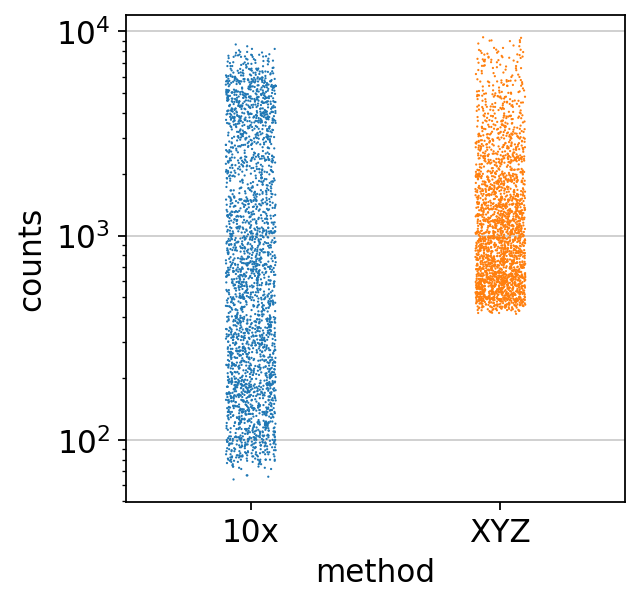

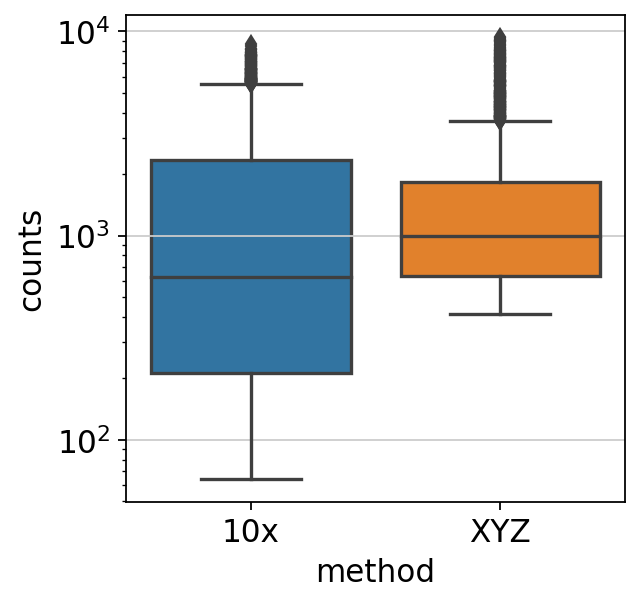

In [43]:
sns.stripplot(data=pd.concat([df_10x, df_XYZ]) ,y='counts',x='method',size=1);
plt.yscale('log')
plt.show()
sns.boxplot(data=pd.concat([df_10x, df_XYZ]), y='counts', x='method');
plt.yscale('log')
plt.show()

In [44]:
(data['10x']['mouse_down'].X.sum(0) > 0).sum()

15481

## Filter for Genes

In [45]:
def my_plot(ax, vals, tupe=None, thresh=None, max_y=None, low=1e-1, hi=2e5):
    ax.hist(vals,bins=np.logspace(np.log10(low),np.log10(hi), 300)) # logspace bins looks great!
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(tupe)
    ax.grid(which='both', alpha=0.5)
    if thresh != None:
        ax.vlines(thresh,0,max_y)
    return

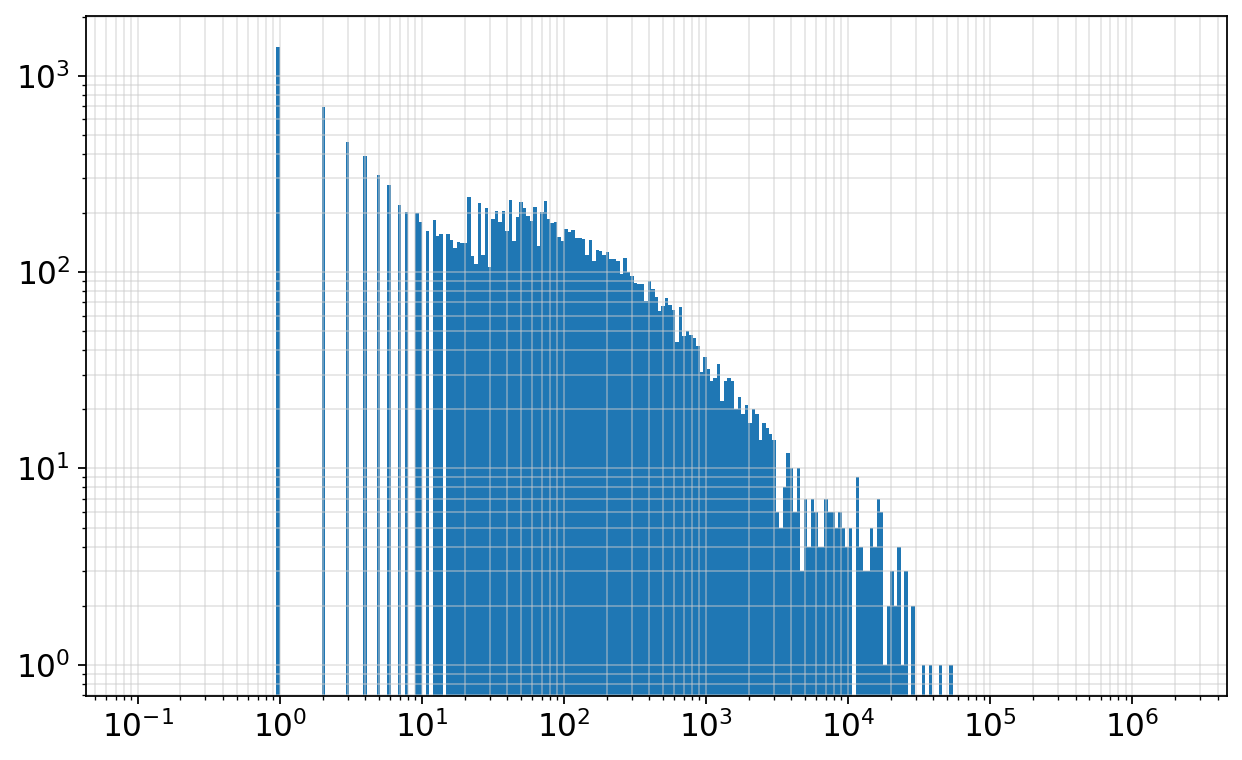

In [46]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
vals = sc.pp.filter_genes(data['10x']['mouse_down'], min_counts=0, inplace=False)[1] # total number of UMIs observed
my_plot(ax, vals, hi=2e6)
plt.tight_layout()

In [47]:
sc.pp.filter_genes(data['10x']['mouse_down'], min_counts=20, inplace=True)

filtered out 21277 genes that are detected in less than 20 counts


In [48]:
data['10x']['mouse_down'].shape

(2703, 9776)

In [49]:
data['10x']['mouse_down'].raw = data['10x']['mouse_down'].copy()

## Normalize and Log

In [50]:
sc.pp.normalize_per_cell(data['10x']['mouse_down'])
sc.pp.log1p(data['10x']['mouse_down'])

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


## Dimension Reduction and Clustering

In [51]:
data['10x']['mouse_down_unscaled'] = data['10x']['mouse_down'].copy()

In [52]:
sc.pp.scale(data['10x']['mouse_down'], max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    ... clipping at max_value 10


computing PCA
    with n_comps=100
    finished (0:00:04)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


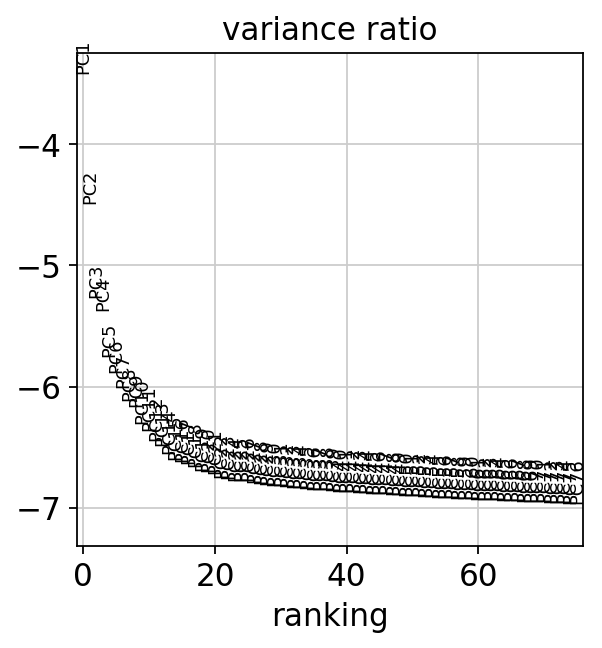

In [53]:
warnings.filterwarnings('ignore')
sc.pp.pca(data['10x']['mouse_down'],n_comps=100)
sc.pl.pca_variance_ratio(data['10x']['mouse_down'],log=True, n_pcs=75)
warnings.filterwarnings('default')

In [54]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(data['10x']['mouse_down'], n_neighbors=15, n_pcs=25) # using all available embeddings, numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 25
    computed neighbors (0:00:00)
    computed connectivities (0:00:04)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


In [55]:
sc.tl.umap(data['10x']['mouse_down'])

computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


In [56]:
sc.tl.tsne(data['10x']['mouse_down'], n_pcs=25)

computing tSNE
    using 'X_pca' with n_pcs = 25
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2703 samples in 0.006s...
[t-SNE] Computed neighbors for 2703 samples in 0.347s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2703
[t-SNE] Computed conditional probabilities for sample 2000 / 2703
[t-SNE] Computed conditional probabilities for sample 2703 / 2703
[t-SNE] Mean sigma: 2.959543
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.756065
[t-SNE] KL divergence after 1000 iterations: 0.874162
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:07)


In [278]:
sc.tl.leiden(data['10x']['mouse_down'], resolution=0.2)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [279]:
sc.tl.leiden(data['10x']['mouse_down'], resolution=0.3, restrict_to=('leiden',['4']))

running Leiden clustering
    finished: found 12 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:00)


In [281]:
stupid_name_clusts = data['10x']['mouse_down'].obs['leiden_R'].dtype.categories
for i, j in zip(stupid_name_clusts, range(len(stupid_name_clusts))):
    data['10x']['mouse_down'].obs['leiden_R'].replace(i, j, inplace=True)
data['10x']['mouse_down'].obs['leiden_R'] = data['10x']['mouse_down'].obs['leiden_R'].astype(int)
data['10x']['mouse_down'].obs['leiden_R'] = data['10x']['mouse_down'].obs['leiden_R'].astype(str)

data['10x']['mouse_down'].obs['leiden'] = data['10x']['mouse_down'].obs['leiden_R'].copy()
data['10x']['mouse_down'].obs.drop(columns='leiden_R', inplace=True)

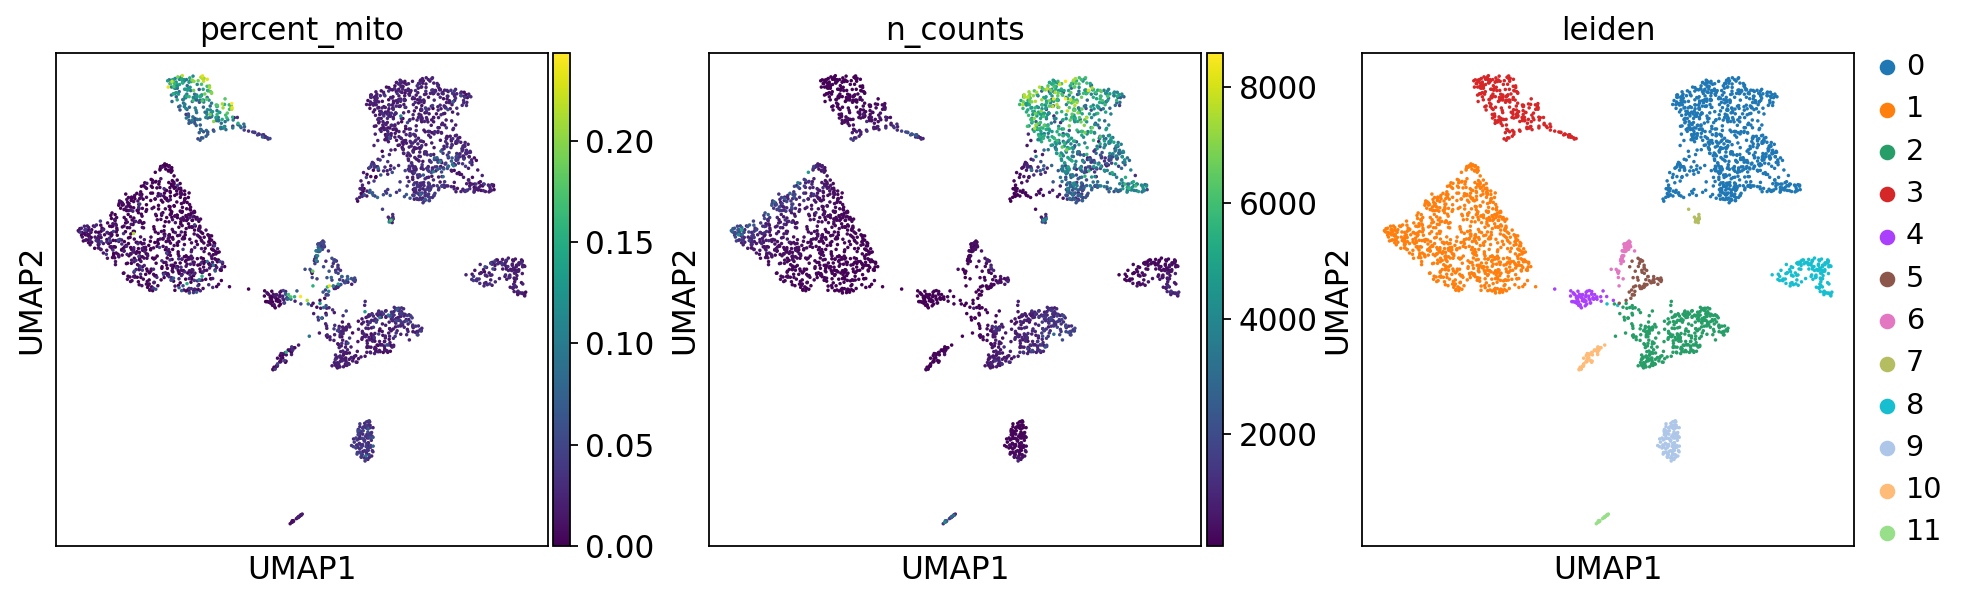

In [283]:
sc.pl.umap(data['10x']['mouse_down'],color=['percent_mito', 'n_counts', 'leiden'], size=10, palette=sc.pl.palettes.default_20)

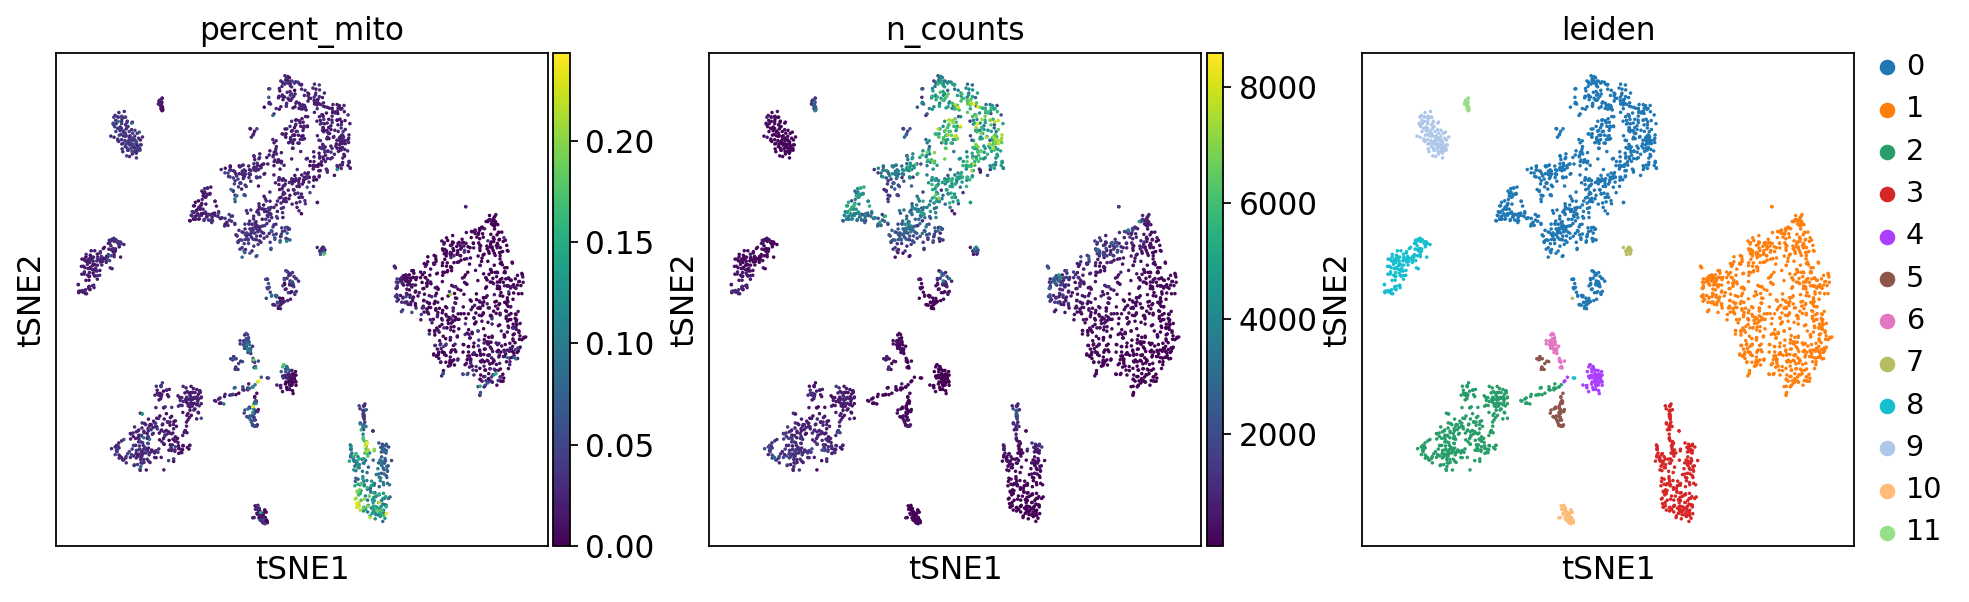

In [284]:
sc.pl.tsne(data['10x']['mouse_down'],color=['percent_mito', 'n_counts', 'leiden'], size=10, palette=sc.pl.palettes.default_20)

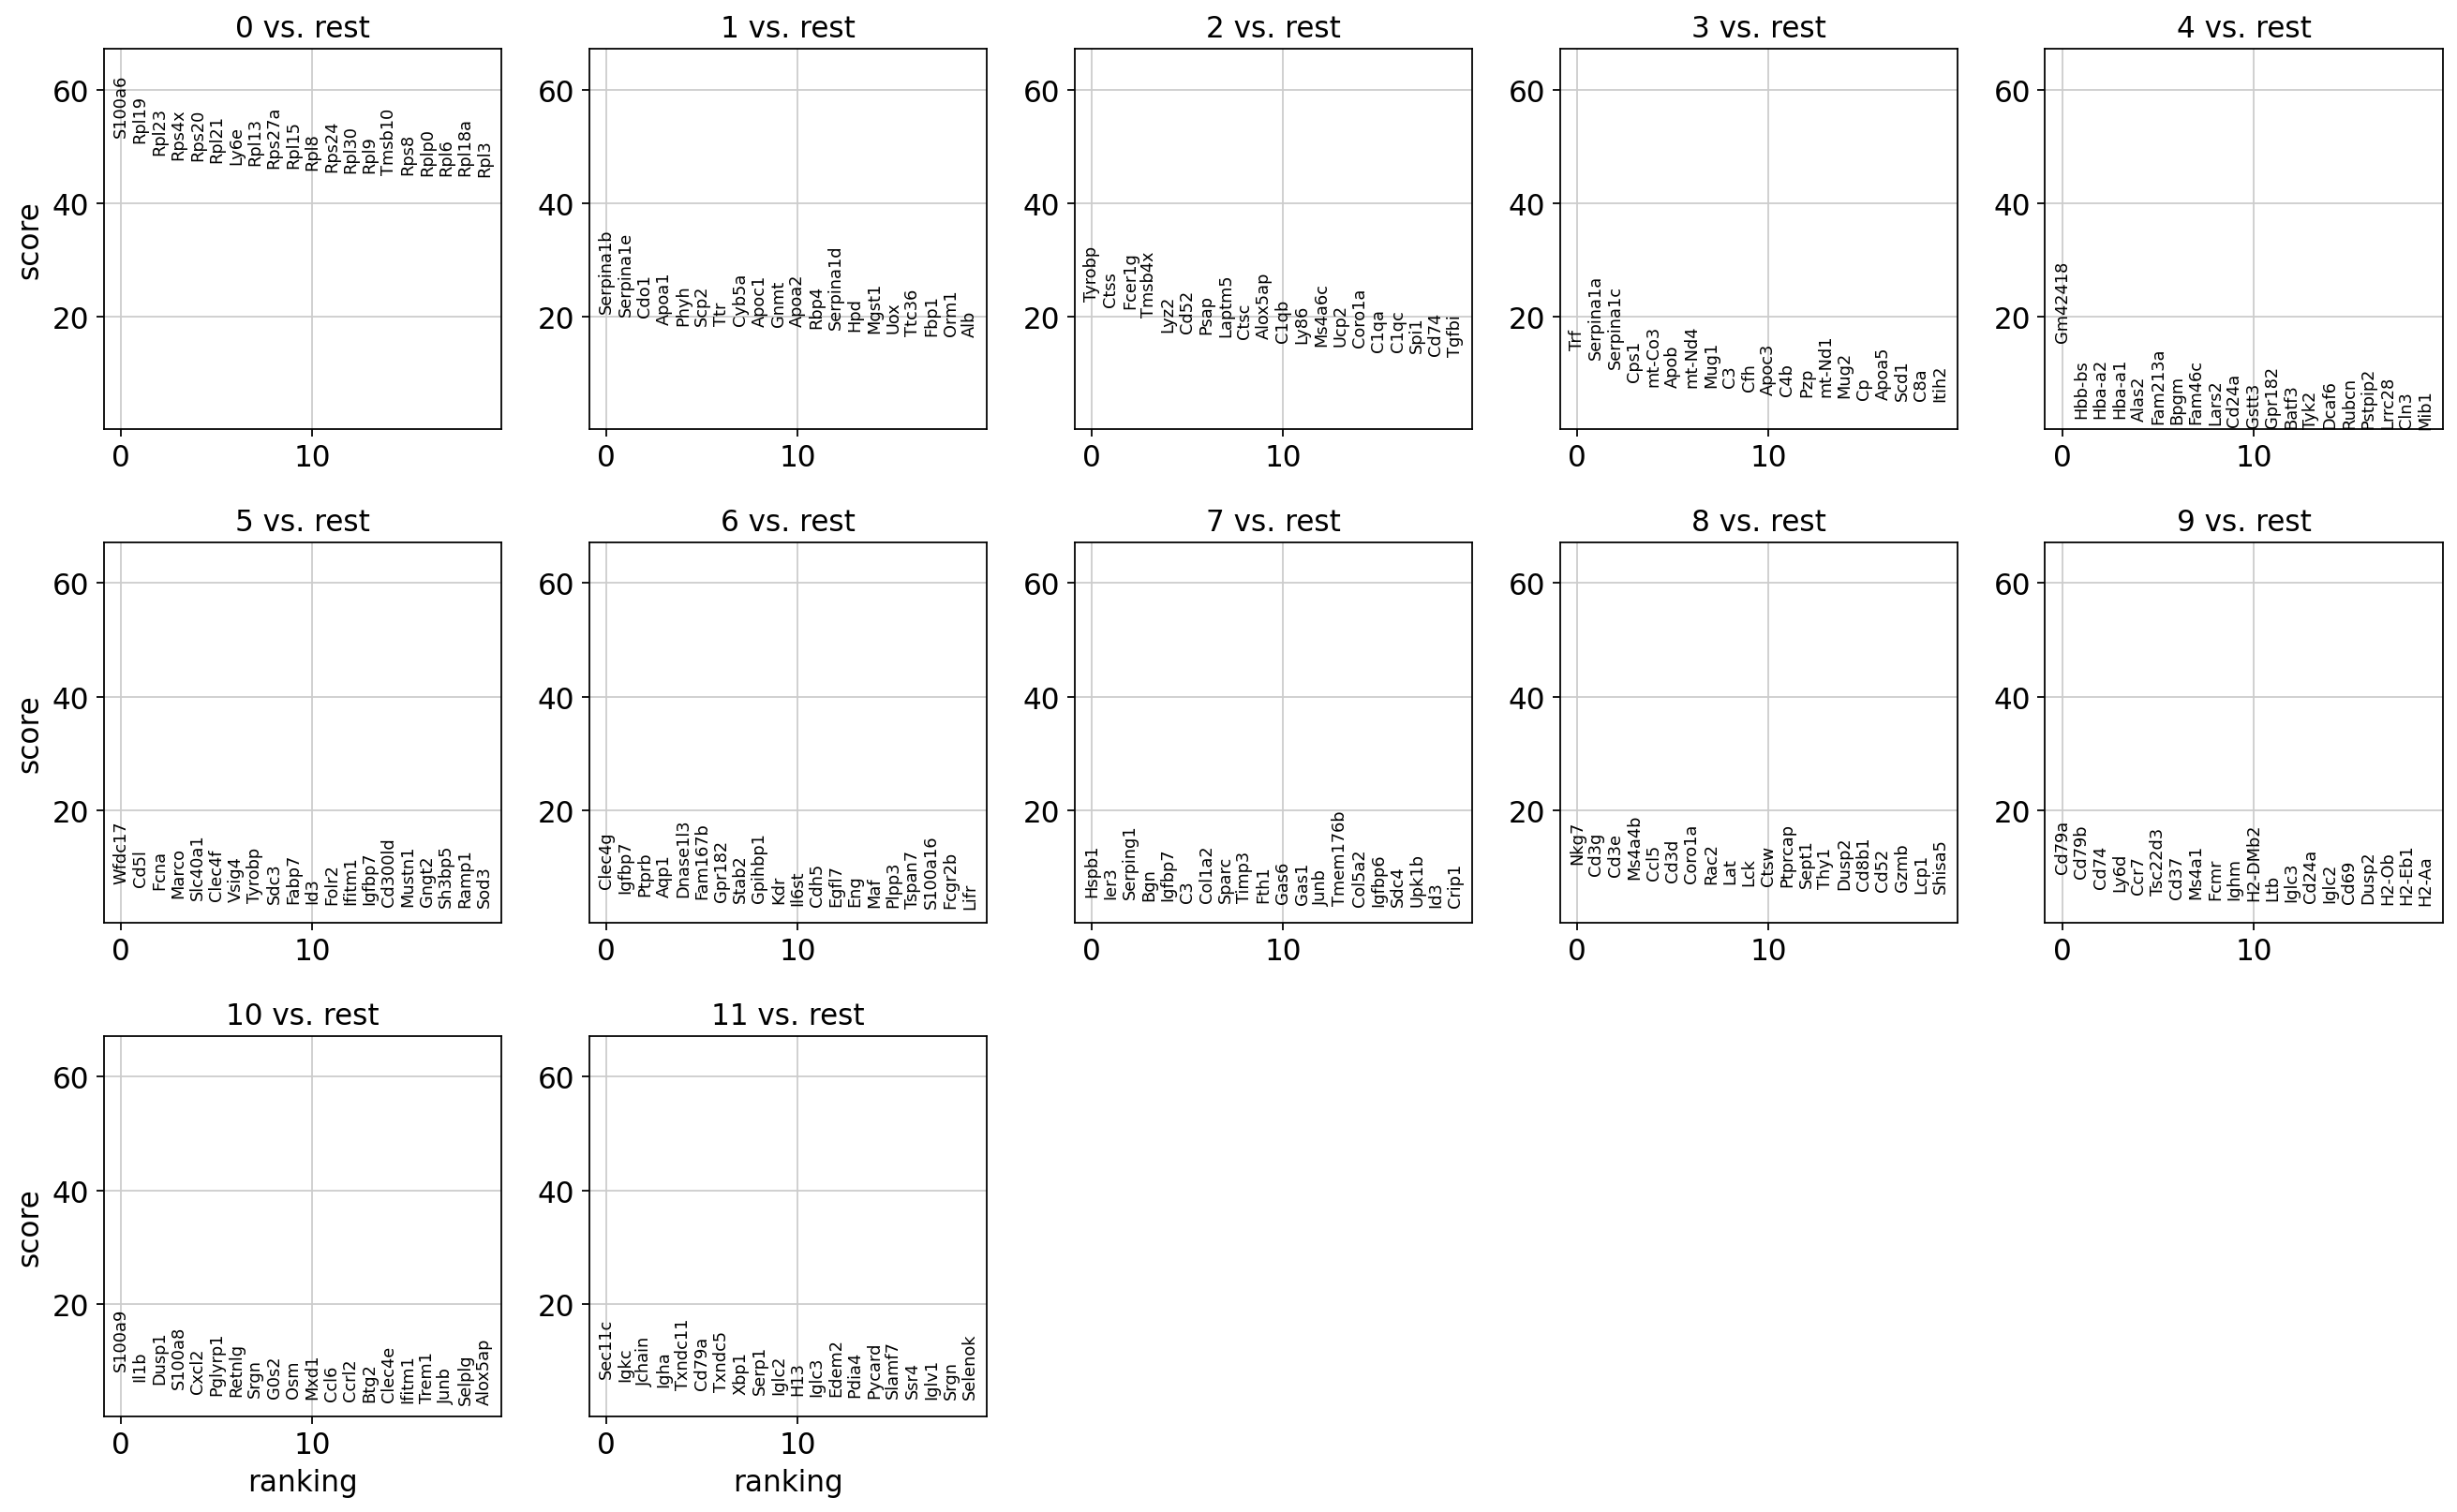

In [285]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(data['10x']['mouse_down'], groupby='leiden', n_genes=20)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(data['10x']['mouse_down'], ncols=5, n_genes=20)
sc.settings.verbosity = 4

In [286]:
for i in data['10x']['mouse_down'].obs['leiden'].dtype.categories:
    print(i + ': ' + ', '.join(data['10x']['mouse_down'].uns['rank_genes_groups']['names'][i][:10]))

0: S100a6, Rpl19, Rpl23, Rps4x, Rps20, Rpl21, Ly6e, Rpl13, Rps27a, Rpl15
1: Serpina1b, Serpina1e, Cdo1, Apoa1, Phyh, Scp2, Ttr, Cyb5a, Apoc1, Gnmt
2: Tyrobp, Ctss, Fcer1g, Tmsb4x, Lyz2, Cd52, Psap, Laptm5, Ctsc, Alox5ap
3: Trf, Serpina1a, Serpina1c, Cps1, mt-Co3, Apob, mt-Nd4, Mug1, C3, Cfh
4: Gm42418, Hbb-bs, Hba-a2, Hba-a1, Alas2, Fam213a, Bpgm, Fam46c, Lars2, Cd24a
5: Wfdc17, Cd5l, Fcna, Marco, Slc40a1, Clec4f, Vsig4, Tyrobp, Sdc3, Fabp7
6: Clec4g, Igfbp7, Ptprb, Aqp1, Dnase1l3, Fam167b, Gpr182, Stab2, Gpihbp1, Kdr
7: Hspb1, Ier3, Serping1, Bgn, Igfbp7, C3, Col1a2, Sparc, Timp3, Fth1
8: Nkg7, Cd3g, Cd3e, Ms4a4b, Ccl5, Cd3d, Coro1a, Rac2, Lat, Lck
9: Cd79a, Cd79b, Cd74, Ly6d, Ccr7, Tsc22d3, Cd37, Ms4a1, Fcmr, Ighm
10: S100a9, Il1b, Dusp1, S100a8, Cxcl2, Pglyrp1, Retnlg, Srgn, G0s2, Osm
11: Sec11c, Igkc, Jchain, Igha, Txndc11, Cd79a, Txndc5, Xbp1, Serp1, Iglc2


In [173]:
def low_de_make(adata, p=0.2, p_of='any', cov='leiden'):
    '''
    adata = adata object with a raw attribute
    p = percentage of cells that should be expressing a gene for it to be reported
    p_of = when subsetting genes to report, at least p percent of cells in ANY cluster ('any') \n
    should be expressing the gene, or only in the provided cluster
    '''
    X = adata.raw.X.copy()
    clusts = adata.obs[cov].dtype.categories
    df = pd.DataFrame(0,index=clusts, columns=adata.raw.var_names.values,dtype=np.float16)
    for clust in clusts:
        clustbool = (adata.obs[cov] == clust).values
        clustX = X[clustbool]
        try:
            clustX = clustX.tocsc()
        except AttributeError:
            from scipy.sparse import csc_matrix
            clustX = csc_matrix(clustX)
        df.loc[clust] = clustX.getnnz(axis=0)/clustX.shape[0]
    if p_of == 'any':
        df = df.iloc[:,df.apply(lambda x: np.any(x > p), axis=0, raw=True).values]
    else:
        df = df.iloc[:,(df.loc[p_of] > p).values]
    return df

def low_de_compare(df, clust, compare=None):
    if type(compare) == type(None): 
        return (df.loc[clust]/df[~(df.index == clust)].mean()).sort_values(ascending=False)
    elif type(compare) == list:
        return (df.loc[clust].mean()/df[(df.index.isin(compare))].mean()).sort_values(ascending=False)

In [348]:
g1 = ['11']
g2 = [i for i in data['10x']['mouse_down'].obs['leiden'].dtype.categories if i not in g1]
# g2 = ['1', '2']

In [349]:
df = low_de_make(data['10x']['mouse_down'], p=0.2, p_of=g1[0], cov='leiden')

In [350]:
de_genes = low_de_compare(df, g1, compare=g2)

In [351]:
print(de_genes[:20])

Igha                inf
Jchain       770.500000
Derl3        729.500000
Iglc1        115.937500
Iglv1         76.125000
Mzb1          73.937500
Igkv1-110     66.000000
Gm30211       63.718750
Fam46c        46.406250
Trp53inp1     44.531250
Slamf7        42.312500
Txndc11       40.875000
Igkc          40.718750
Ctla4         38.781250
Iglc3         37.843750
Iglc2         31.375000
Tspan13       30.875000
Blnk          22.390625
Glipr1        21.687500
Gimap1        17.265625
dtype: float16


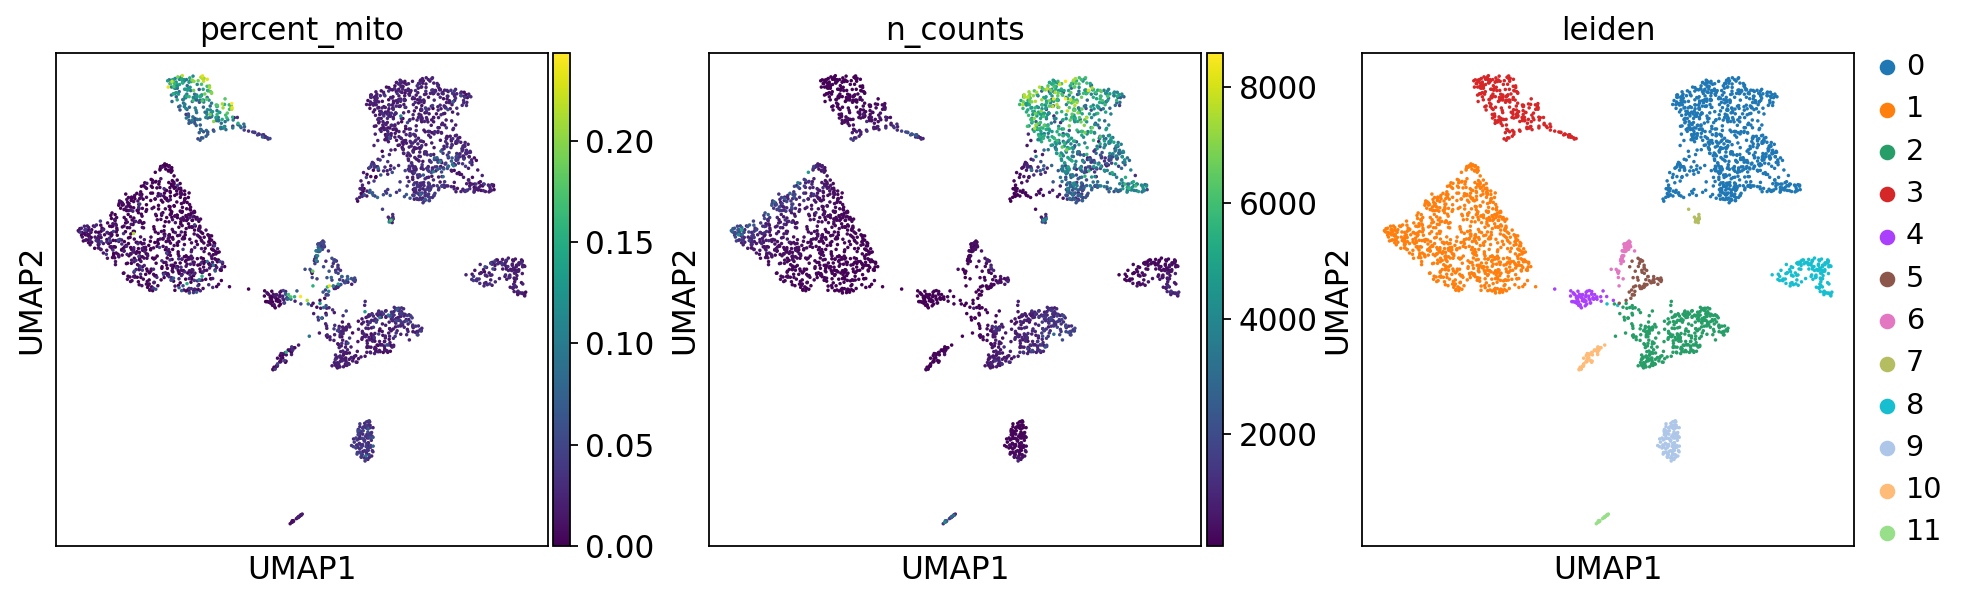

In [8]:
sc.pl.umap(data['10x']['mouse_down'],color=['percent_mito', 'n_counts', 'leiden'], size=10, palette=sc.pl.palettes.default_20)

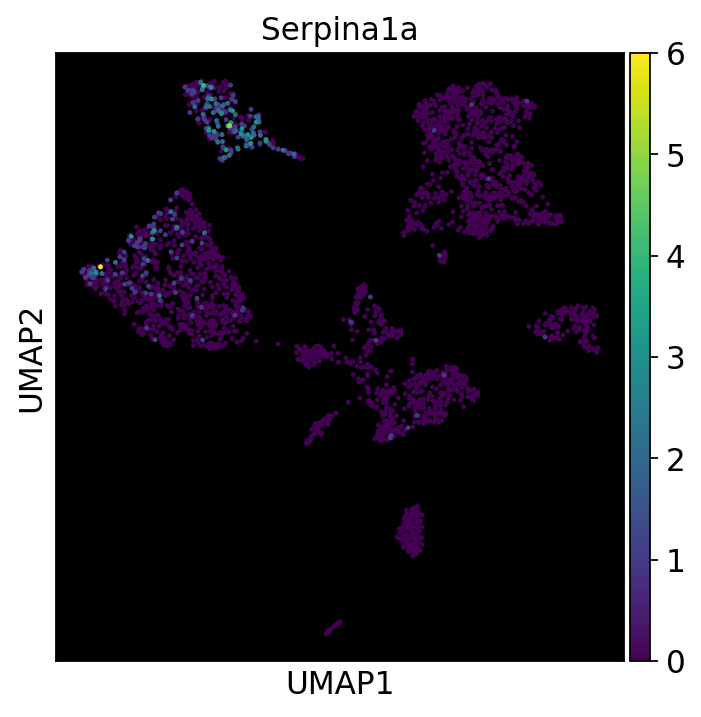

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
for color, ax in zip(['Serpina1a'], [ax]):
    ax.set_facecolor('black')
    sc.pl.umap(data['10x']['mouse_down'], color=color, ax=ax, show=False, return_fig=False, size=20)

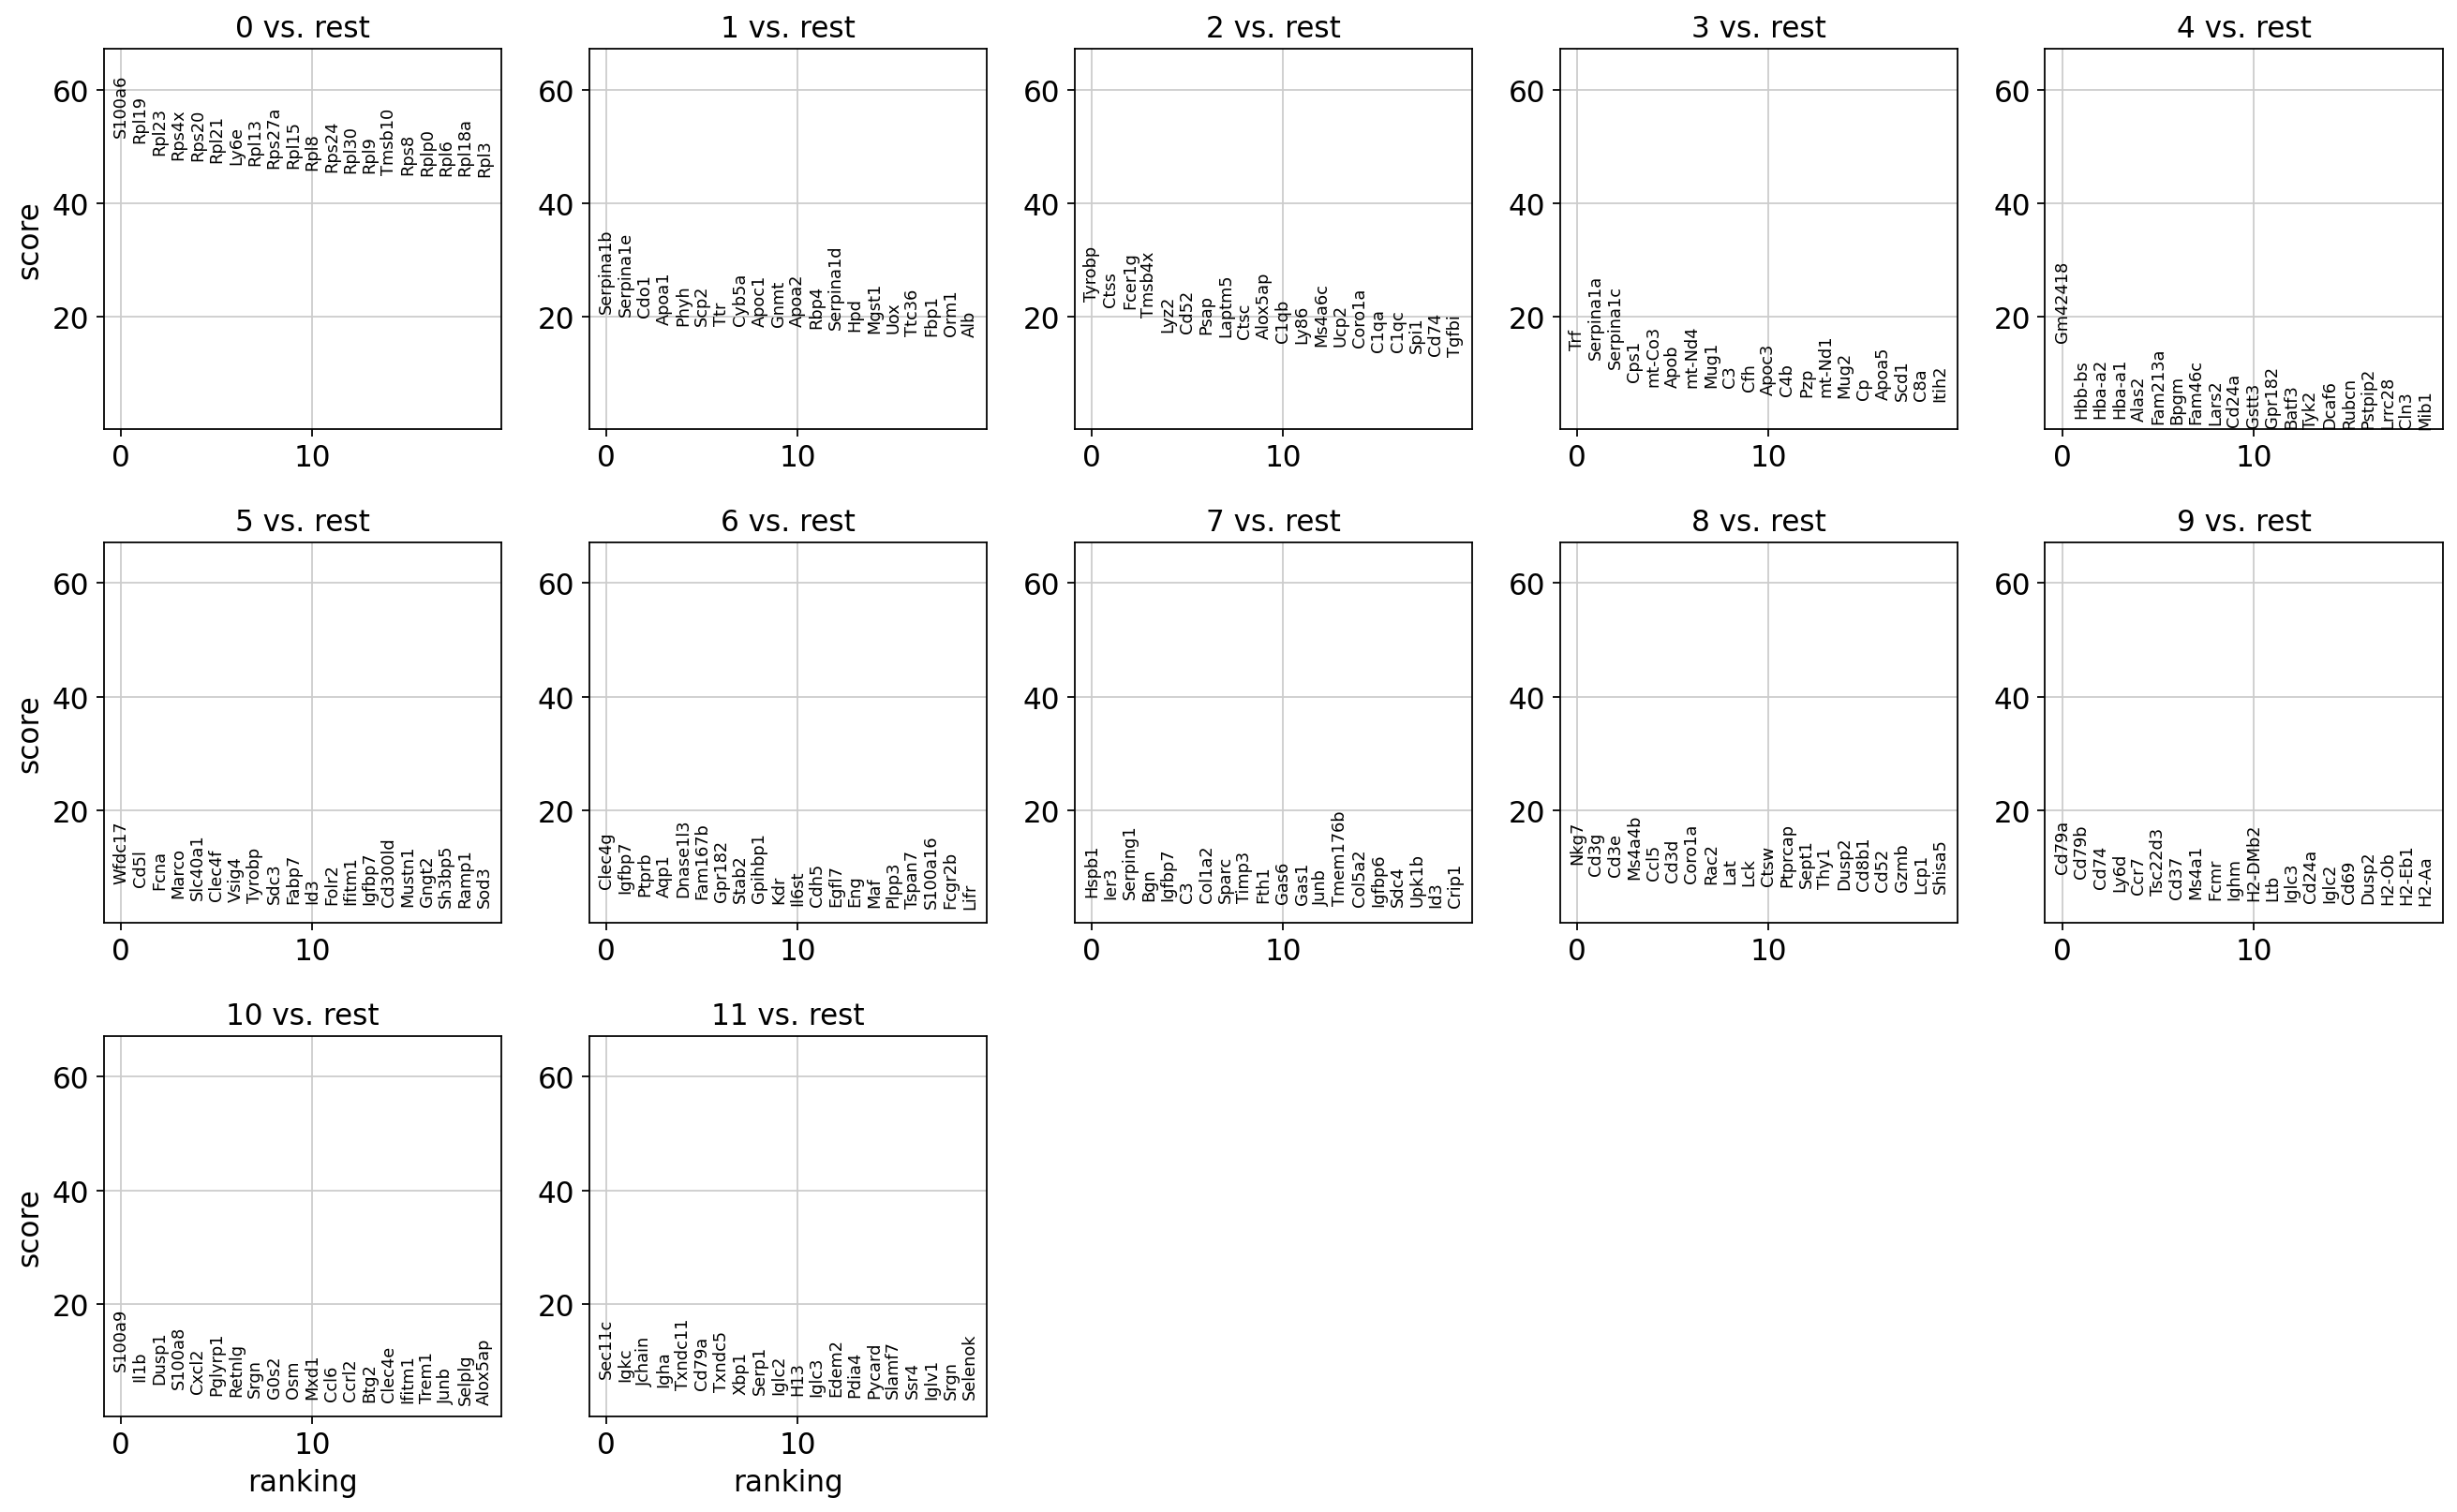

In [289]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.pl.rank_genes_groups(data['10x']['mouse_down'], ncols=5, n_genes=20)
sc.settings.verbosity = 4

In [10]:
ctdict = dict()
ctdict['MC38'] = [0, 7]
ctdict['Hepatocyte'] = [1, 3]
ctdict['Myeloid'] = [2, 3]
ctdict['T Cell'] = [8]
ctdict['Erythroid'] = [4]
ctdict['Kupffer'] = [5]
ctdict['LSEC'] = [6]
ctdict['B Cell'] = [9]
ctdict['Neutrophil'] = [10]
ctdict['Plasma cell'] = [11]
data['10x']['mouse_down'].obs['celltype'] = data['10x']['mouse_down'].obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        data['10x']['mouse_down'].obs['celltype'].replace(str(clust), ct, regex=True, inplace=True)
data['10x']['mouse_down'].obs['celltype'] = data['10x']['mouse_down'].obs['celltype'].astype('category')

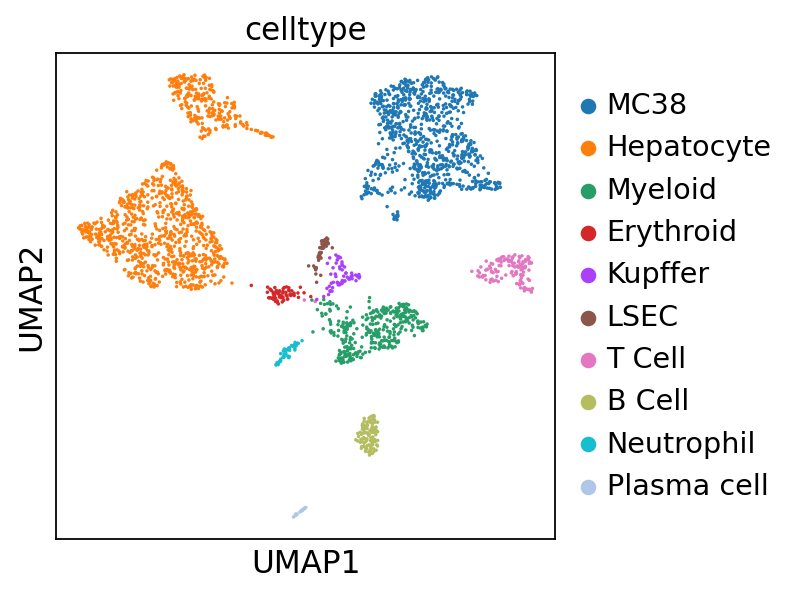

In [11]:
sc.pl.umap(data['10x']['mouse_down'],color=['celltype'], size=10)

In [12]:
# with open('/data/xyzeq/10x/5prime_liver/downsample/10x.down.pkl','wb') as file:
#     pkl.dump(data['10x'], file)

In [7]:
with open('/data/xyzeq/10x/5prime_liver/downsample/10x.down.pkl','rb') as file:
    data['10x'] = pkl.load(file)